# **Image Captioning**

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import re
import os
from time import time
import json
import collections
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import *
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.models import Model, load_model
from keras.preprocessing import image
import pickle

## Data Preprocessing

In [96]:
 # function to read text from .txt file 
    
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [97]:
# Read captions 

captions = readTextFile("/content/drive/MyDrive/Image Captioning/flickr8k_data/captions.txt")
captions = captions.split('\n')[1:-1]

In [98]:
# Dictionary to map each image to list of captions it has

descriptions = {}

for cap in captions:
    img_name,caption = cap.split('.jpg,')
    
    # if the image id is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
        
    descriptions[img_name].append(caption)

In [99]:
# function to preprocess caption text

def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

In [100]:
# Clean captions

for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [101]:
# Vocab - contains set of all distinct words

vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print("Vocab Size : %d"% len(vocab))

Vocab Size : 8424


In [102]:
# Total no of words across all sentences

total_words = []
for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("Total Words %d"%len(total_words))

Total Words 373803


In [103]:
# Filter words from vocab according to certain threshold freq

counter = collections.Counter(total_words)
freq_cnt = dict(counter)

# Sort this dictionary according to the freq count
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

# Filter
threshold = 10
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

### Read Train and Test images id

In [104]:
train_file_data = readTextFile("/content/drive/MyDrive/Image Captioning/flickr8k_data/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("/content/drive/MyDrive/Image Captioning/flickr8k_data/Flickr_8k.testImages.txt")

In [105]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [106]:
# Prepare description for the training data
# Tweak - Add <s> and <e> token to our data

train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

## CNN model to extract image features 

### Transfer Learning (using pretrained Resnet model)

In [107]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [108]:
# output feature vector dimension will be (1,2048) 

model_new = Model(model.input,model.layers[-2].output)

### Calculate and store the image feature vector for training images

In [109]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0) # reshape to (1,224,224,3)
    # Noramalisation
    img = preprocess_input(img)
    return img

In [110]:
def encode_img(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1,1))
    return feature_vector

In [ ]:
encoding_train = {}
# image_id -> feature vector extracted from Resnet Image

IMG_PATH = "/content/drive/MyDrive/Image Captioning/flickr8k_data/Images/"

for ix,img_id in enumerate(train):
    img_path = IMG_PATH + img_id + '.jpg'
    encoding_train[img_id] = encode_img(img_path)

In [ ]:
# Store everything to the disk //

with open("encoded_train_features.pkl",'wb') as f:
    pickle.dump(encoding_train,f)

In [111]:
# Load data training and testing

with open("/content/drive/MyDrive/Image Captioning/encoded_train_features.pkl",'rb') as f:
    encoding_train = pickle.load(f)

In [112]:
word_to_idx = {}  # map all words of vocab to integer
idx_to_word = {}  # map all integer to their corresponding word

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [113]:
# Two special words

word_to_idx["startseq"] = 1846
idx_to_word[1846] = "startseq"

word_to_idx["endseq"] = 1847
idx_to_word[1847] = "endseq"

vocab_size = len(word_to_idx) + 1
print("Vocab Size",vocab_size)

Vocab Size 1848


In [114]:
# get maximum length of caption from training data

max_len = 0

for key in train_descriptions.keys():
    for cap in descriptions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

33


## Data Generator 
- generates data for training in batches

In [115]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2,y = [],[],[]
    
    n=0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    # 0 denote padding
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                
                if n==batch_size:
                    yield ([np.array(X1),np.array(X2)],np.array(y))
                    
                    X1,X2,y = [],[],[]
                    n=0

## Word Embeddings (Glove Vector)

In [116]:
# read word embedding vector (Glove vector)

f = open("/content/drive/MyDrive/Image Captioning/glove.6B.50d.txt",encoding='utf8')

In [117]:
# dictionary to map word to vector

embedding_index = {}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding
    
f.close()

In [118]:
# function to get word embeddings for vocab words 

def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
    
    return matrix

In [119]:
embedding_matrix = get_embedding_matrix()
print(embedding_matrix.shape)

(1848, 50)


## Model

In [120]:
# take image feature vector as input

input_img_feature = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_feature)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [121]:
# captions as input

input_caption = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_caption)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [122]:
# combine ouput from both layers and outputs the probability of each vocab word

decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

#combined Model
model = Model(inputs=[input_img_feature,input_caption],outputs=outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 33)]         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 33, 50)       92400       input_7[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_6[0][0]                    
____________________________________________________________________________________________

In [123]:
# Embedding-layer 
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False  
model.compile(optimizer='adam',loss='categorical_crossentropy')

### Training

In [ ]:
epochs = 70
batch_size = 3
steps = len(train_descriptions)/batch_size

In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
    model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

## Making Predictions

In [136]:
model.load_weights("/content/drive/MyDrive/Image Captioning/model_weights/model_70.h5")

In [137]:
# inputs image feature vector

def predict_caption(photo):
    
    # start token
    in_text = "startseq" 
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,value=0,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax()  # word with max prob always
        word = idx_to_word[ypred]
        in_text += ' ' + word
        
        if word == "endseq":
            break
    
    # remove start and end token
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

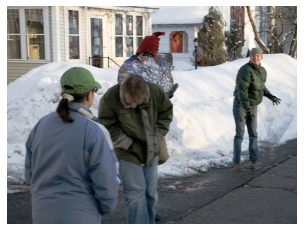

man in black jacket and jeans stands before two men


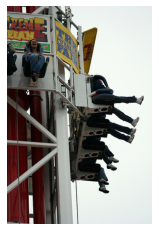

man in red shirt is sitting on the floor with flag on his head


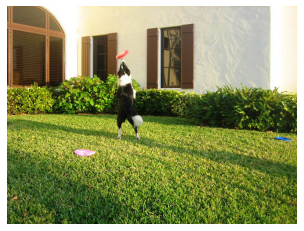

boy in blue shirt is running on the grass


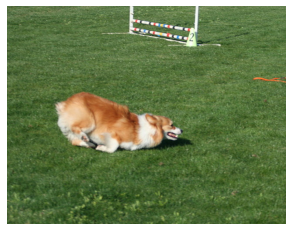

brown dog is running through the grass


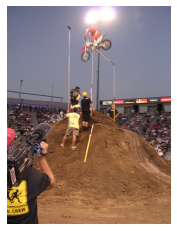

man in motocross gear is jumping over hurdle


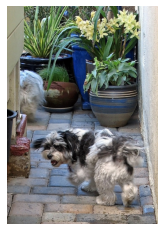

dog sniffs on plants


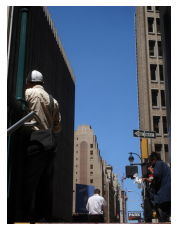

man in black shirt is standing in front of wooden bench


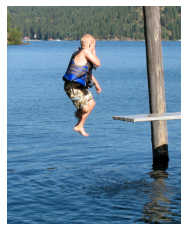

man in swimming trunks is jumping into the water


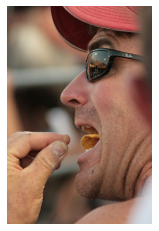

man with nose and headphones


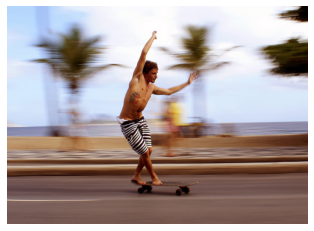

skinny boy in blue shorts runs on the beach


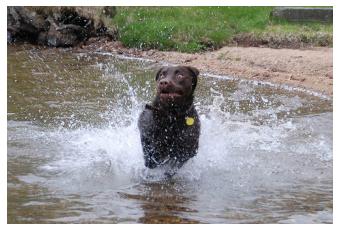

black dog is running through the water


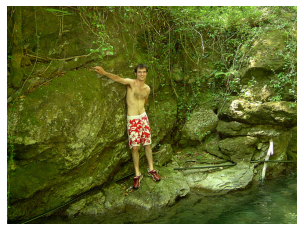

man in blue shirt is jumping off of rock into the water


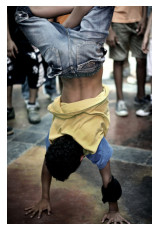

boy in red shirt is running on the grass


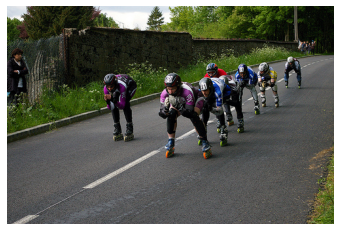

man in red shirt and jeans is jogging on busy street


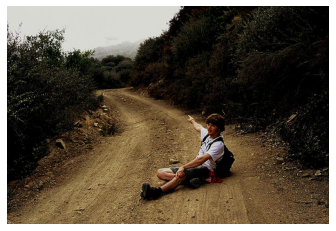

group of people are sitting on rock overlooking the river


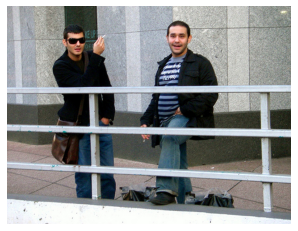

man in blue shirt is sitting on bench


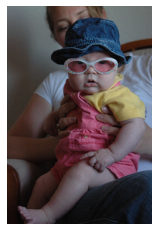

young girl with blond hair is sitting on the grass


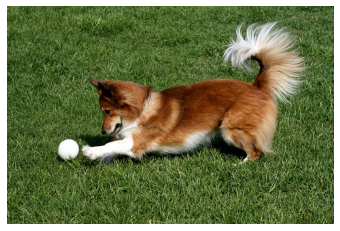

dog is running through the grass


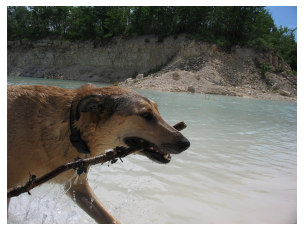

brown dog is shaking off water on pavement


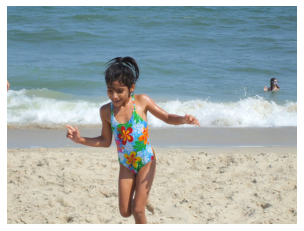

boy plays in the surf at the beach


In [154]:
# Pick some random images and show result

for i in range(20):
    idx = np.random.randint(0,1000)
    all_img_names = test
    image_name = all_img_names[idx]
    photo_2048 = encode_img(IMG_PATH+image_name+'.jpg').reshape((1,2048))

    
    i = plt.imread(IMG_PATH+image_name+'.jpg')
    plt.axis("off")
    plt.imshow(i)
    plt.show()
    caption = predict_caption(photo_2048)
    print(caption)